In [179]:
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import re
import io
import json
import ftfy
import numpy as np
import imutils
import math
import matplotlib.pyplot as plt

In [273]:
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~='''
#document_type = input("Please enter the document type in small letters: Passport, ID card or Driving License")
#document_type = document_type.title()
#print(document_type)
#if document_type== "License" or document_type:
    #ln = input("Enter your address: ")
    #ln = ln.title()
#elif document_type=="Passport":
    #ps = input("Enter your passport Number: ")
    #ps = ps.title()
#elif document_type=="Id card":
    #id_ = input("Enter your ID Number: ")
    #id_ = id_.title()
#else:
    #print("invalid document type")
fname = input("Enter your first name: (first letter should be capital of every word!)")
fname.title()
lname = input("Enter your last name: (first letter should be capital of every word!)")
lname.title()
datob = input("Enter your DOB: (Format: MM/DD/YYYY)")
dob_no_punc = ""
for char in datob:
    if char not in punctuations:
        dob_no_punc = dob_no_punc + char
dob_no_punc = datetime.strptime(dob_no_punc, "%m%d%Y")
dob_no_punc = dob_no_punc.date()
add = input("Enter your Address: ")
add = add.title()
add_np = ""
for char in add:
    if char not in punctuations:
        add_np = add_np + char

#datoi = input("Enter Issue Date: (Format: MM/DD/YYYY)")
#doi_no_punc = ""
#for char in datoi:
    #if char not in punctuations:
        #doi_no_punc = doi_no_punc + char
        
#datoe = input("Enter Date of Expiry of your card: (Format: MM/DD/YYYY) ")
#doe_no_punc = ""
#for char in datoe:
    #if char not in punctuations:
        #doe_no_punc = doe_no_punc + char

Enter your first name: (first letter should be capital of every word!)Doe
Enter your last name: (first letter should be capital of every word!)Jane
Enter your DOB: (Format: MM/DD/YYYY)09/16/1990
Enter your Address: 123 Anywhere


('[[1766, 215], [202, 298], [233, 1268], [1817, 1202]]', 1500, 2000)


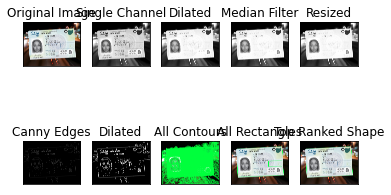

In [181]:
filename = "test_images/120.jpg"

### convenience plotting functions
def ss(thing):
    cv2.imwrite("about/%s.tif" % (ra.random()), thing)
    plt.subplot(121),plt.imshow(thing,cmap = 'gray')
    plt.show()

def dd(thing, square):
    extra = thing.copy()
    cv2.drawContours(extra, [square], -1, (0,255,60), 3)
    ss(extra)


# Loading image
img = cv2.imread(filename)
img_copy = img.copy()[:,:,::-1] 
height = img.shape[0]
width = img.shape[1]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)) # matrix of ones

def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

squares = []
all_contours = []

for gray in cv2.split(img):
    dilated = cv2.dilate(src = gray, kernel = kernel, anchor = (-1,-1))
    blured = cv2.medianBlur(dilated, 7)
    

    small = cv2.pyrDown(img, dstsize =(width//2, height//2))
    oversized = cv2.pyrUp(small, dstsize = (width, height))
    
    
    for thrs in range(0, 255, 26):
        if thrs == 0:
            edges = cv2.Canny(oversized, threshold1 = 0, threshold2 = 100, apertureSize = 5)
            _next = cv2.dilate(src = edges, kernel = kernel, anchor = (-1,-1))
        else:
            retval, _next = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
        
        contours, hierarchy = cv2.findContours(_next, mode = cv2.RETR_LIST, method = cv2.CHAIN_APPROX_SIMPLE)
        

        for cnt in contours:
            all_contours.append(cnt)
            cnt_len = cv2.arcLength(cnt, True)
            cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
            if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                cnt = cnt.reshape(-1, 2)
                max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                if max_cos < 0.1:
                    squares.append(cnt)

# ranking of shapes
def rank(square):
    formatted = np.array([[s] for s in square], np.int32)
    x,y,wid,hei = cv2.boundingRect(formatted)
    max_distance_from_center = math.sqrt(((width / 2))**2 + ((height / 2))**2)
    distance_from_center = math.sqrt(((x + wid / 2) - (width / 2))**2 + ((y + hei / 2) - (height / 2))**2)
    
    height_above_horizontal = (height / 2) - y if y + hei > height / 2 else hei
    width_left_vertical = (width / 2) - x if x + wid > width / 2 else wid
    horizontal_score = abs(float(height_above_horizontal) / hei - 0.5) * 2
    vertical_score = abs(float(width_left_vertical) / wid - 0.5) * 2

    if cv2.contourArea(formatted) / (width * height) > 0.98:
        return 5 
    else:
        bounding_box = np.array([[[x,y]], [[x,y+hei]], [[x+wid,y+hei]], [[x+wid,y]]], dtype = np.int32)
        return (distance_from_center / max_distance_from_center +
                cv2.contourArea(formatted) / cv2.contourArea(bounding_box) +
                cv2.contourArea(formatted) / (width * height) +
                horizontal_score +
                vertical_score)

sorted_squares = sorted(squares, key=lambda square: rank(square))

def mask_image(img, square, opacity = 0.80):
    overlay = img.copy()
    cv2.fillPoly(overlay, [square], (255, 255, 255))
    inverse_overlay = cv2.bitwise_not(overlay)
    img2 = cv2.bitwise_xor(inverse_overlay, img)
    cv2.addWeighted(img2, opacity, img, 1 - opacity, 0, img)

if len(sorted_squares) and rank(sorted_squares[0]) < 3 :
    cv2.drawContours(img, squares, -1, (0,255,255), 1) # draw all found squares
    cv2.drawContours(img, [sorted_squares[0]], -1, (0,255,60), 3)
    finalsquares = json.dumps(sorted_squares[0].tolist()), height, width
    print(finalsquares)
else:
    print("document not found")
### Some plotting code
plt.subplot2grid((2,5), (0,0)),plt.imshow(img_copy)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
gray = cv2.split(img_copy)[0]
plt.subplot2grid((2,5), (0,1)),plt.imshow(gray, cmap = 'gray')
plt.title('Single Channel'), plt.xticks([]), plt.yticks([])
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
dilated = cv2.dilate(src = gray, kernel = kernel, anchor = (-1,-1))
plt.subplot2grid((2,5), (0,2)),plt.imshow(dilated, cmap = 'gray')
plt.title('Dilated'), plt.xticks([]), plt.yticks([])
blured = cv2.medianBlur(dilated, 7)
plt.subplot2grid((2,5), (0,3)),plt.imshow(blured, cmap = 'gray')
plt.title('Median Filter'), plt.xticks([]), plt.yticks([])


small = cv2.pyrDown(blured, dstsize = (width // 2, height // 2))
oversized = cv2.pyrUp(small, dstsize = (width, height))
plt.subplot2grid((2,5), (0,4)),plt.imshow(oversized, cmap = 'gray')
plt.title('Resized'), plt.xticks([]), plt.yticks([])

edges = cv2.Canny(oversized, threshold1 = 0, threshold2 = 50, apertureSize = 3)
plt.subplot2grid((2,5), (1,0)),plt.imshow(edges, cmap = 'gray')
plt.title('Canny Edges'), plt.xticks([]), plt.yticks([])
dilated = cv2.dilate(src = edges, kernel = kernel, anchor = (-1,-1))
plt.subplot2grid((2,5), (1,1)),plt.imshow(dilated, cmap = 'gray')
plt.title('Dilated'), plt.xticks([]), plt.yticks([])

img_with_contours = img_copy.copy()
cv2.drawContours(img_with_contours, all_contours, -1, (0,255,60), 3)
plt.subplot2grid((2,5), (1,2)),plt.imshow(img_with_contours)
plt.title('All Contours'), plt.xticks([]), plt.yticks([])

img_with_squares = img_copy.copy()
cv2.drawContours(img_with_squares, squares, -1, (0,255,60), 3)
plt.subplot2grid((2,5), (1,3)),plt.imshow(img_with_squares)
plt.title('All Rectangles'), plt.xticks([]), plt.yticks([])

img_with_top_square = img_copy.copy()
cv2.drawContours(img_with_top_square, [sorted_squares[0]], -1, (0,255,60), 3)
plt.subplot2grid((2,5), (1,4)),plt.imshow(img_with_top_square)
plt.title('Top Ranked Shape'), plt.xticks([]), plt.yticks([])

plt.show()



In [182]:
def sort_coords(raw_coords):
    
    left = sorted(raw_coords, key = lambda p: p[0])[0:2]
    right = sorted(raw_coords, key = lambda p: -p[0])[0:2]
    tl, bl = sorted(left, key = lambda p: p[1])
    tr, br = sorted(right, key = lambda p: p[1])
    return [tl, bl, br, tr]

def skew(pt1,pt2):

    a1,b1 = pt1; a2,b2 = pt2;
    if a2 == a1:
        return 90
    else:
        return (math.atan((b1 - b2) / (a1 - a2)) * 180 / np.pi)

def cropper():
    json_arr = finalsquares[0]
    s_height = finalsquares[1]
    s_width = finalsquares[2]
    print(json_arr)
    print(s_height)
    print(s_width)
    
    s_height, s_width = [(s_height), (s_width)]
    landscape = s_width > s_height
    img = cv2.imread(filename)
    #img = imutils.resize(img, width = 600)
    l_height,l_width = img.shape[0:2]
    raw_coords = json.loads(json_arr)
    # raw_coords could be in any order, sort them...
    center_x = sum([p[0] for p in raw_coords]) / 4
    center_y = sum([p[1] for p in raw_coords]) / 4
    tl,bl,br,tr = sort_coords(raw_coords)
    
    # compute skew
    sides = [[tl[::-1], tr[::-1]], [tr, br], [br[::-1], bl[::-1]], [bl, tl]]
    avg_skew = sum([abs(skew(*s)) for s in sides]) / 4
    rotate_right = skew(*sides[0]) > 0 # negative first skew angle
    rotation_angle = (abs(avg_skew - 90) if rotate_right else avg_skew - 90)
    
    upw = lambda s: int(round(s * float(l_width) / s_width)) # scale up width
    uph = lambda s: int(round(s * float(l_height) / s_height)) # scale up height
    
    rot_mat = cv2.getRotationMatrix2D(center = (upw(center_x), uph(center_y)), angle = rotation_angle, scale = 1)
    rotated_img = cv2.warpAffine(src = img, M = rot_mat, dsize = (l_width,l_height), flags = cv2.INTER_CUBIC)
    
    wid, hei = [abs(tr[0] - tl[0]), abs(bl[1] - tl[1])]
    crop = cv2.getRectSubPix(image = rotated_img, patchSize = (upw(wid), uph(hei)), center = (upw(center_x), uph(center_y)))
    cv2.imwrite("corrected.jpg", crop)

    return "Cropping done!"

cropper()

[[1766, 215], [202, 298], [233, 1268], [1817, 1202]]
1500
2000


'Cropping done!'

In [183]:
image = cv2.imread("corrected.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
temp1 = 255 - cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_vertical)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
temp2 = 255 - cv2.morphologyEx(image, cv2.MORPH_CLOSE, horizontal_kernel)
temp3 = cv2.add(temp1, temp2)
img = cv2.add(temp3, image)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, img)

True

In [184]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
text = pytesseract.image_to_string(Image.open(filename), lang = 'eng')
# add +hin after eng within the same argument to extract hindi specific text - change encoding to utf-8 while writing
os.remove(filename)


In [185]:
# Cleaning all the gibberish text
text = ftfy.fix_text(text)
text = ftfy.fix_encoding(text)
#matches = datefinder.find_dates(text_save)
#for match in matches:
    #print(match)

#print(text)

In [186]:
text = text.lower()
text = text.title()
text_new = ""
for char in text:
    if char not in punctuations:
        text_new = text_new + char
        
lines = text_new.split("\n")
non_empty_lines = [line for line in lines if line.strip() != ""]
text_save = ""
for line in non_empty_lines:
      text_save += line + "\n"

print(text_save)
#print(text_new)

F  A ° John R Kasich Governor Donald J Petit Registrar Bmv Ex
A 70Lo0  Driverlicense Bat
Gi570
Sno Ab123456
12Doe
Jane
8 123 Anywhere St
Anytown Oh 12345
9 Class 4Bexp 9Aend 12 Rest
D 01212021 M B
15Sex A6Hgt 8Eyes
F77502 Bey Allay
4Aiss 07022018 Ane D
Pre Dee Wxr771234567 Ov 161000
3008 09161990 Forces



In [261]:
import re
from dateparser.search import search_dates
dates = text_save.replace('\n',' ').split(" ")
dates = [s for s in dates if s.isdigit()]
dates = [s for s in dates if len(s) == 8]
dates = search_dates(str(dates))
dates_f = []
for i in dates:
    dates_f.append(i[1])
dates_final = []
for i in dates_f:
    dates_final.append(i.date())
    
print(dates_final)

[datetime.date(2021, 1, 21), datetime.date(2018, 7, 2), datetime.date(1990, 9, 16)]


In [188]:
#save into txt file
text_output = open('outputbase.txt', 'a', encoding='utf-8')
text_output.write(text_save + "\n\n\n\n")
text_output.close()

In [189]:
# Initializing data variable
#text_final = " ".join(text_save.split())
text_final = text_save.replace("\n", " ")
text_final = text_final.strip()
#text_final = text_final.split(" ")
print(text_final)

F  A ° John R Kasich Governor Donald J Petit Registrar Bmv Ex A 70Lo0  Driverlicense Bat Gi570 Sno Ab123456 12Doe Jane 8 123 Anywhere St Anytown Oh 12345 9 Class 4Bexp 9Aend 12 Rest D 01212021 M B 15Sex A6Hgt 8Eyes F77502 Bey Allay 4Aiss 07022018 Ane D Pre Dee Wxr771234567 Ov 161000 3008 09161990 Forces


In [276]:
def check_fname():
    if fname in text_final:
        print("first name is correct")
        return True
    else:
        print("first name is not correct")
        return False
def check_lname():
    if lname in text_final:
        print("last name is correct")
        return True
    else:
        print("last name is not correct")
        return False
#def check_number():
    #if ln:
        #if ln[1:] in text_final:
            #print("Licence no. is correct")
            #return True
        #else:
            #print("Licence no. is not correct")
            #return False
    #elif ps:
        #if ps in text_final:
            #print("Passport no. is correct")
            #return True
        #else:
            #print("Passport no. is not correct")
            #return False
    #elif id_:
        #if id_ in text_final:
            #print("ID no. is correct")
            #return True
        #else:
            #print("ID no. is not correct")
            #return False
def check_dob():
    if dob_no_punc in dates_final:
        print("DOB. is correct")
        return True
    else:
        print("DOB is not correct")
        return False
#def check_doi():
    #if doi_no_punc in text_final:
        #print("Date of Issue is correct")
        #return True
    #else:
        #print("Date of Issue is not correct")
        #return False
#def check_doe():
    #if doe_no_punc in text_final:     
        #print("Date of Expiry is correct")
        #return True
    #else:
        #print("Date of Expiry is not correct")
        #return False
def add_ver():
    ask = input("Does your uploaded document have valid address? Enter 'Y' for Yes or 'N' for No.")
    if ask == "y" or ask == "Y":
        if add in text_final:
            print("Address is verified")
            return True
        else:
            print("Your address is incorrect.")
            return False
    elif ask == "n" or ask == "N":
        return True
    else:
        print("invalid command. Please Enter y or n.")
        return False
        
#check if date of expiry is later than current date!
from datetime import datetime
present = datetime.now()
#print(present)
#date_check = []
#for d in dates:
    #expiry_date = datetime.strptime(d, "%m%d%Y")
    #date_check.append(expiry_date)
#print(date_check)
#print(dates_final)
def date_verify():
    for i in dates_final:
        if i > present.date():
            print("Your card is valid")
            return True
        else:
            print("your card is expired")
            return False

def verification():
    if all((check_fname(), check_lname(),check_dob(),add_ver(),date_verify())):
        print("\nverified!")
        return True
    else:
        print("\nSorry, Not verified")
        return False

In [277]:
#save the verified data in Json file.
if verification() is True:
    data = {}
    data['Name'] = fname  + " " + lname
    data['Date of Birth'] = datob
    data["Address"] = add
    #if ln:
        #data['Licence Number'] = ln
    #elif ps:
        #data['Passport Number'] = ps
    #elif id_:
        #data['ID Number'] = id_
    #data['Date of Issue'] = datoi
    #data['Date of Expiry'] = datoe
    
    try:
        to_unicode = unicode
    except NameError:
        to_unicode = str
        
    # Write JSON file
    with io.open('data.json', 'w', encoding='utf-8') as outfile:
        str_ = json.dumps([data], indent=4, sort_keys=True, separators=(',', ': '), ensure_ascii=False)
        outfile.write(to_unicode(str_))
        
    # Read JSON file
    with open('data.json', encoding = 'utf-8') as data_file:
        data_loaded = json.load(data_file)
    
    # Reading data back JSON(give correct path where JSON is stored)
    with open('data.json', 'r', encoding= 'utf-8') as f:
        ndata = json.load(f)
        
    print(ndata)
else:
    print("Sorry, your data is not verified that is why it cannot be saved!")

first name is correct
last name is correct
DOB. is correct
Does your uploaded document have valid address? Enter 'Y' for Yes or 'N' for No.y
Address is verified
Your card is valid

verified!
[{'Address': '123 Anywhere', 'Date of Birth': '09/16/1990', 'Name': 'Doe Jane'}]
